# Dynamic optimization of human walking speeds

## Optimization of energy and time predicts dynamic speeds for human walking (Carlisle and Kuo 2022)

Take walks of varying distances, and show how the optimal trajectory has
an inverted-U velocity profile, with peak speed that increases with
distance up to about 12 steps, leveling off thereafter. The cost
function is net mechanical work, plus a linear cost of time with
coefficient ctime.

### Go for a single walk

Take a walk of 10 steps, starting and ending at rest. Find the optimal
push-offs that minimize total work. The optimization is performed with
`optwalktime` which uses a time cost (relative to work) of `tchange`.

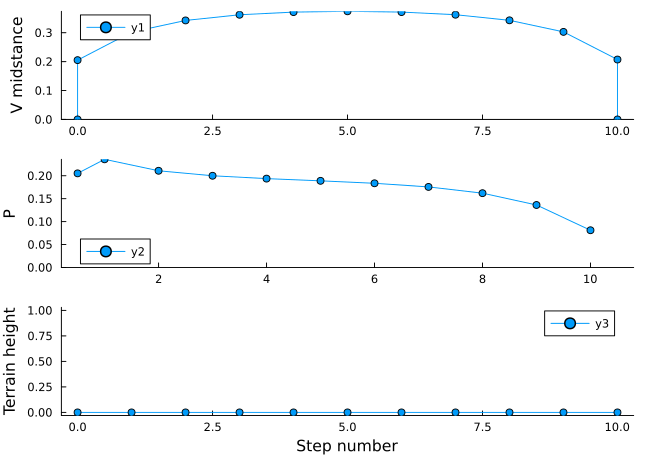

In [1]:
using DynLoco, Plots; #plotlyjs()

wstar4 = findgait(WalkRW2l(α=0.35,safety=true), target=:speed=>0.3, varying=:P)
ctime = 0.015 # cost of time, to encourage hurrying
tchange = 1.75 # boundary condition time to get up to speed (arbitrary, excluded from optimization) 
p = plot() 
nsteps = 10
result = optwalktime(wstar4, nsteps, ctime=ctime) # optimize work and time
multistepplot(result) # plot speed, push-off, terrain trajectories

All quantities are plotted dimensionlessly, with base units of body mass
$M$, leg length $L$, and gravitational acceleration $g$. Thus speed is
normalized by $\sqrt(gL)$ and time by $\sqrt(L/g)$. For a typical leg
length of $L = 1 \mathrm{m}$, the dimensional speed is about 1.25 m/s,
and step time about 0.55 s.

### Go for walks of verying distance

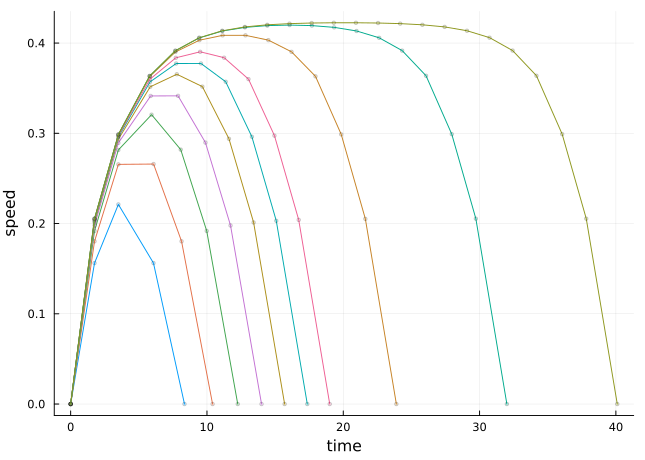

In [2]:
p = plot() 
walksteps = [1, 2, 3, 4, 5, 6, 7, 10, 15, 20] # take walks of this # of steps
results = Array{MultiStepResults,1}(undef,0) # store each optimization result here
for (i,nsteps) in enumerate(walksteps)
    result = optwalktime(wstar4, nsteps, ctime=ctime) # optimize with a cost of time
    plotvees!(p, result, tchange=tchange, usespline=false, color=i, speedtype=:shortwalks, rampuporder=1, markersize=2) # plot instantaneous body speed vs. time
    push!(results, result) # add this optimization to results array
end
Plots.display(p) # instantaneous speed vs. distance profiles

Here the speeds are plotted as “body speed” each step, to match IMU.
Model is parameterized by mid-stance speed each step, but IMU data only
yields strides. As described by Carlisle and Kuo (2022), we use
estimated mid-stance times to estimate body speed.

## Compare three objectives: Energy-Time, min-COT, constant acceleration

Walk a fixed number of steps, starting and ending at rest. The
objectives are:

-   **Energy-Time** minimizes total energy (positive work) plus
    proportional time cost
-   **min-COT** walks at a constant speed that minimizes cost of
    transport (energy per weight and distance traveled), with a
    trapezoidal speed profile. This is achieved by minimizing deviation
    from minCOT speed, to allow model to accelerate to that speed.
-   **Constant accel** accelerates at a constant rate, to yield a
    triangular speed profile. Uses a minimum variance objective to
    produce a constant rate of velocity change.

Compare for a fixed number of steps.

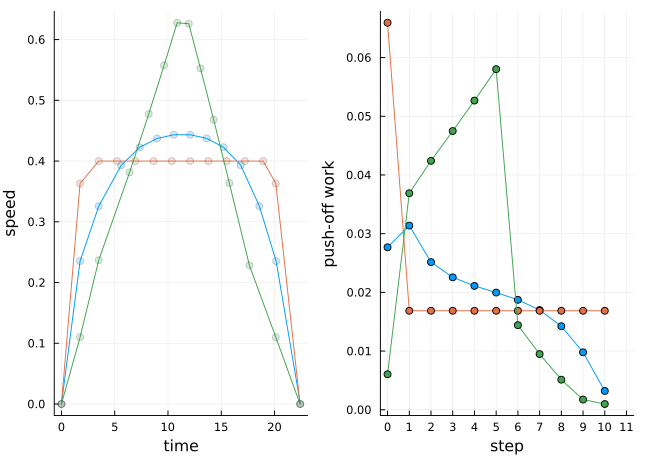

In [3]:
# A minCOT nominal gait
wstar4n = findgait(WalkRW2l(α=0.35, safety=true), target=:speed=>0.4, varying=:P) # use a speed of 0.4 to match minCOT
nsteps = 10
ctime = 0.0195
tchange = 1.75
nominalresult=optwalktime(wstar4n, nsteps, ctime = ctime, boundarywork=true) # to compare with our usual solution

# minCOT walk. optwalkvar minimizes variance from nominal
minvarresult=optwalkvar(wstar4n, nsteps, boundarywork=true)

# steady acceleration walk, which tries to maintain same
# acceleration each step, resulting in a triangular speed
# profile
A = 0.0655 # 1.9*wstar4n.vm/(nsteps*onestep(wstar4n).tf) # acceleration
v0 = 0.11 # 0.8*A*tchange # a couple acceleration constants
# chosen by hand to allow smooth transition from initiation
# to push-off.

constaccelresult = optwalktriangle(wstar4n, nsteps, A = A, boundarywork=false,boundaryvels=(v0,v0))

# Make the plots
p = plot(layout=(1,2))
plotvees!(p[1],nominalresult, tchange=tchange, rampuporder=1, usespline = false, markershape=:circle,speedtype=:shortwalks)
plotvees!(p[1],minvarresult, tchange=tchange, rampuporder=1, usespline = false,markershape=:circle, speedtype=:shortwalks)
plotvees!(p[1],constaccelresult, tchange=tchange, rampuporder=1, usespline = false,markershape=:circle, speedtype=:shortwalks, seriescolor=:auto)
plot!(p[2],[0:nsteps+1], [1/2*nominalresult.vm0^2; nominalresult.steps.Pwork; NaN],markershape=:circle,seriescolor=:auto)
plot!(p[2],[0:nsteps+1], [1/2*minvarresult.vm0^2; minvarresult.steps.Pwork; NaN],markershape=:circle,xticks=0:nsteps+1)
plot!(p[2],[0:nsteps+1], [1/2*constaccelresult.vm0^2; constaccelresult.steps.Pwork; NaN],markershape=:circle,xticks=0:nsteps+1,seriescolor=:auto)
plot!(p[2],xlabel="step", ylabel="push-off work", legend=false)
energytimework = 1/2*nominalresult.vm0^2 + sum(nominalresult.steps.Pwork)
mincotwork = 1/2*minvarresult.vm0^2 + sum(minvarresult.steps.Pwork)
trianglework = (1/2*constaccelresult.vm0^2 + sum(constaccelresult.steps.Pwork))/(1/2*nominalresult.vm0^2 + sum(nominalresult.steps.Pwork))
Plots.display(p)

Quantify the three predictions. The energy cost for each walk consists
of the positive work for gait initiation plus the positive push-off work
for all steps. Negative work is ignored, because equal magnitudes of
positive and negative work are performed for this task. If there are
constant efficiencies for muscles to perform positive and negative work,
the physiological cost of negative work is proportional to positive
work. This affects the total metabolic cost, but does not affect the
optimal solutions.

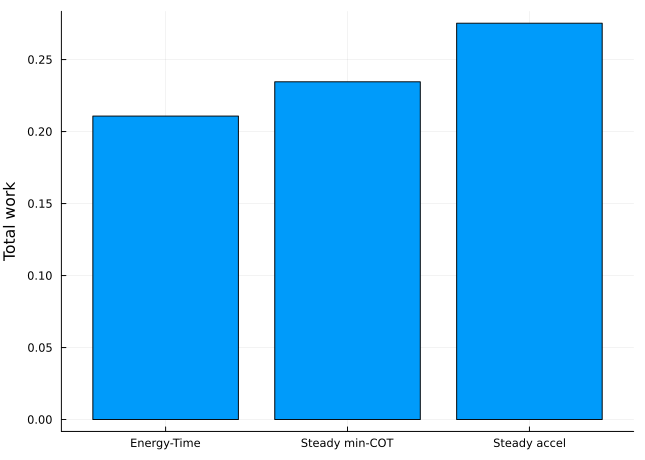

In [4]:
using Markdown
 
threecosts = [1/2*nominalresult.vm0^2 + sum(nominalresult.steps.Pwork), 1/2*minvarresult.vm0^2 + sum(minvarresult.steps.Pwork), 1/2*constaccelresult.vm0^2 + sum(constaccelresult.steps.Pwork)]
bar(threecosts,xticks=((1,2,3),("Energy-Time", "Steady min-COT", "Steady accel")),legend=false,ylabel="Total work")

In [5]:
using Markdown
Markdown.parse("""
The energy-time work is $(threecosts[1]). 
The min-COT work is $(threecosts[2]).
The const accel work is $(threecosts[3]).

Minimization of cost of transport is not energetically optimal, because it is less costly to vary speed dynamically. In particular, the fast speed-up of minCOT is very costly. 
""")

# Julia code

This page is viewable as [Jupyter notebook](shortwalks.ipynb), [plain
Julia](shortwalks.jl) text, or [HTML](shortwalks.html).

## References

Carlisle, R. Elizabeth, and Arthur D. Kuo. 2022. “Optimization of Energy
and Time Predicts Dynamic Speeds for Human Walking.” bioRxiv.
<https://doi.org/10.1101/2022.07.15.500158>.